In [2]:
import numpy as np
import torch
from torch.fft import fftshift, ifftn
from matplotlib import pyplot as plt

In [3]:
fx1D = torch.linspace(-np.pi/(3.2e-3), np.pi/(3.2e-3), 128)
fy1D = torch.linspace(-np.pi/(3.2e-3), np.pi/(3.2e-3), 128)
[fx2D, fy2D] = torch.meshgrid(fx1D, fy1D)
k2D = torch.sqrt(fx2D**2 + fy2D**2) * 128
theta2D = torch.arctan2(fy2D, fx2D)

/Users/luke/miniforge3/envs/pact/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 1.0, 'Wavefront')

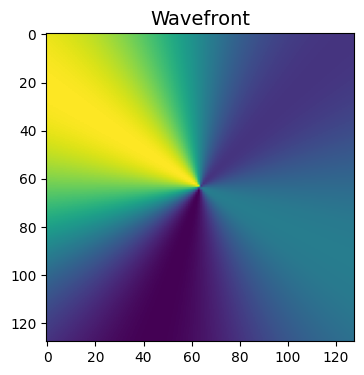

In [4]:
def wavefront(C0, C1, phi1, C2, phi2):
    return lambda theta: C0 + C1 * torch.cos(theta + phi1) + C2 * torch.cos(2 * theta + phi2)

def PSF(theta, k, w, delay):
    tf = (torch.exp(-1j*k*(delay - w(theta))) + torch.exp(1j*k*(delay - w(theta+np.pi)))) / 2
    psf = fftshift(ifftn(tf, dim=[-2,-1]), dim=[-2,-1]).real
    psf /= psf.sum(axis=(-2,-1))
    return psf

w = wavefront(2e-5, 2e-5, 3*np.pi/4, 2e-5, -2*np.pi/3)

plt.figure(figsize=(4, 4))
plt.imshow(w(theta2D))
plt.title('Wavefront', fontsize=14)

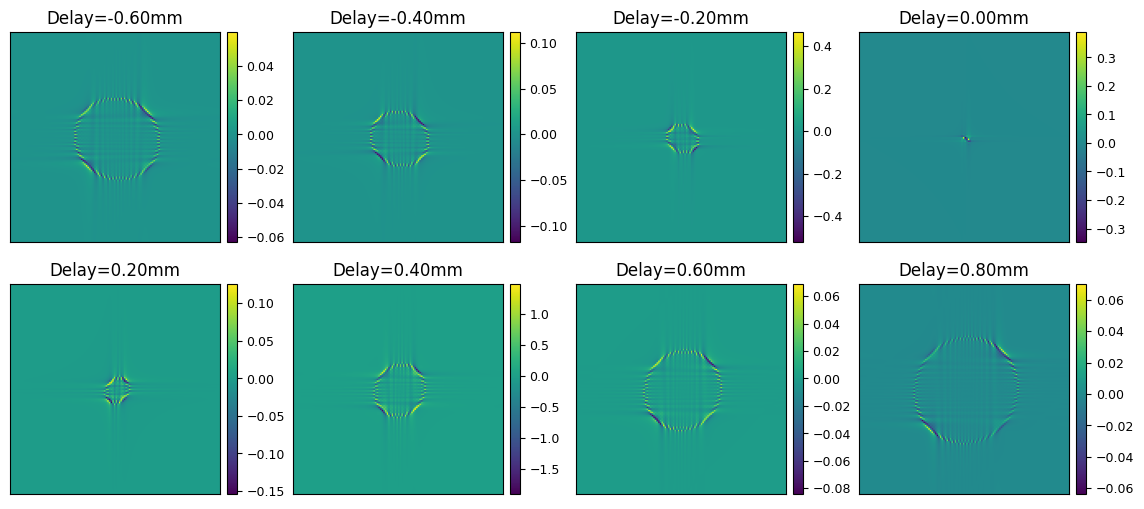

In [38]:
n_delays = 8
delay_step = 2e-4
delays = torch.linspace(-(n_delays/2-1), n_delays/2, n_delays) * delay_step
psfs = []
for delay in delays:
    psfs.append(PSF(theta2D, k2D, w, delay))
    
fig = plt.figure(figsize=(14, 6))
for i in range(8):
    ax = plt.subplot(2,4,i+1)
    plt.imshow(psfs[i])
    plt.title('Delay={:.2f}mm'.format(delays[i]*1e3), fontsize=12)
    plt.xticks([])
    plt.yticks([])
    cax = fig.add_axes([ax.get_position().x1+5e-3, ax.get_position().y0, 7.e-3, ax.get_position().height])
    cb = plt.colorbar(cax=cax)
    cb.ax.tick_params(labelsize=9)
# plt.tight_layout()